On perlmutter: use kernel pytorch-1.13.1

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import pickle

import os
import torch

from numba import cuda 

from helpers.make_BC import *
from helpers.train_BC import *
from helpers.plotting import *
from helpers.evaluation import *

seed = 8

In [15]:
# computing

device = cuda.get_current_device()
device.reset()

# set the number of threads that pytorch will use
torch.set_num_threads(2)

# set gpu device
device = torch.device( "cuda" if torch.cuda.is_available() else "cpu")
print( "Using device: " + str( device ), flush=True)

Using device: cuda


In [16]:
# load in the data

bands = ["SBL", "IBL", "SR", "IBH", "SBH"]
data_dict = {}


flow_training_id = "eta_eta"

flow_training_dir = os.path.join("models", f"{flow_training_id}/")

with open(f"models/{flow_training_id}/flow_samples", "rb") as infile: 
    data_dict = pickle.load(infile)
    
with open(f"models/{flow_training_id}/configs.txt", "rb") as infile: 
    configs = infile.readlines()
    print(configs[0])
    

b"feature_set = ['muon_iso03', 'amuon_iso03', 'dimu_pt', 'dimu_eta', 'dimu_mass']\n"


In [17]:
feature_set = ['muon_iso03', 'amuon_iso03', 'dimu_pt', 'dimu_eta', 'dimu_mass']

## Evaluate the SB Samples

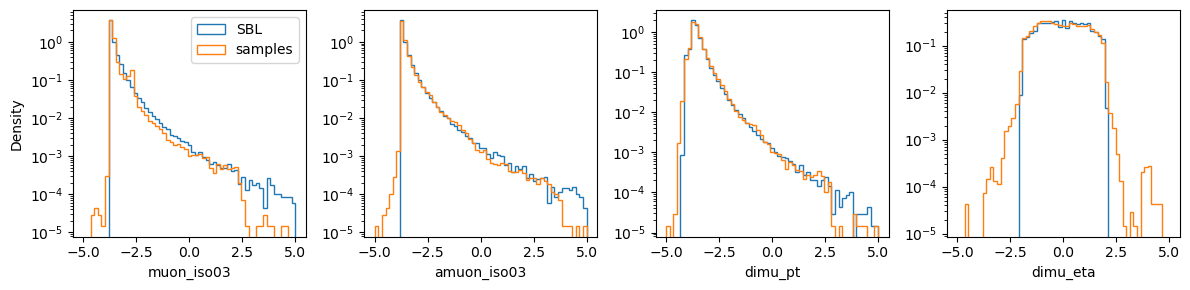

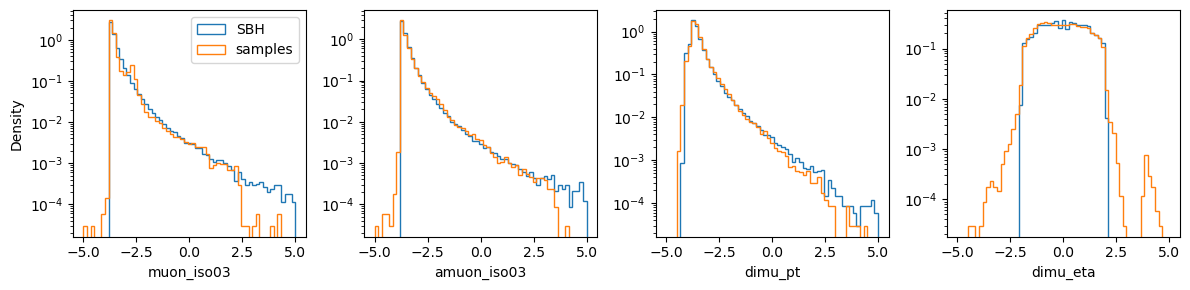

In [36]:
def hist_all_features(samples, labels, feature_set, plot_bound=3, yscale_log=False):
      
    scaled_feature_bins = [np.linspace(-plot_bound, plot_bound, n_bins) for i in range(len(feature_set))]   
    
    n_features = len(feature_set)
    fig, ax = plt.subplots(1, n_features, figsize = (3*n_features, 3))
        

    for i, feat in enumerate(feature_set):
        for j, samp in enumerate(samples):
            ax[i].hist(samp[:,i], bins = scaled_feature_bins[i], histtype = "step", density = True, label = labels[j])
         
        if yscale_log:
            ax[i].set_yscale("log")
        ax[i].set_xlabel(feat)
    ax[0].legend()
    ax[0].set_ylabel("Density")
    plt.tight_layout()
    plt.show()
  
        
hist_all_features([data_dict["SBL"], data_dict["SBL_samples"]], ["SBL", "samples"], feature_set[:-1], plot_bound = 5, yscale_log = True)
hist_all_features([data_dict["SBH"], data_dict["SBH_samples"]], ["SBH", "samples"], feature_set[:-1], plot_bound = 5, yscale_log = True)



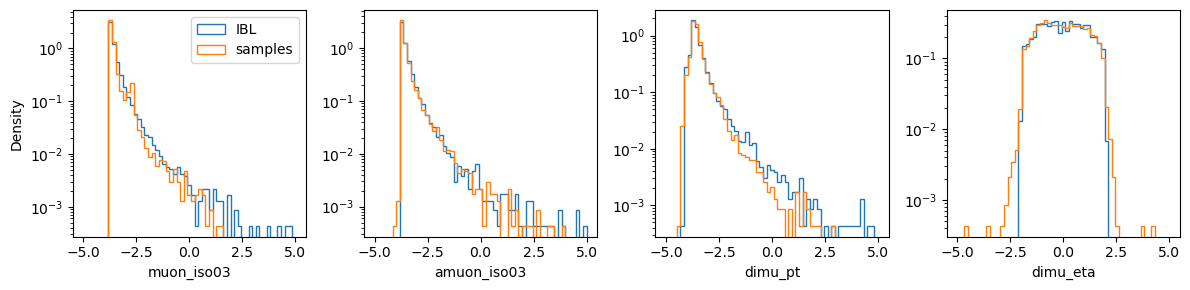

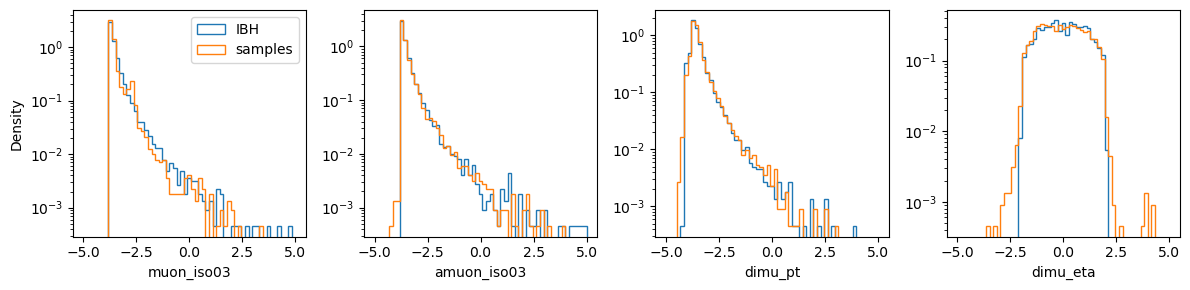

In [33]:
hist_all_features([data_dict["IBL"], data_dict["IBL_samples"]], ["IBL", "samples"], feature_set[:-1], kwargs_dict_bands, plot_bound = 5, yscale_log = True)
hist_all_features([data_dict["IBH"], data_dict["IBH_samples"]], ["IBH", "samples"], feature_set[:-1], kwargs_dict_bands, plot_bound = 5, yscale_log = True)



# Fancier things below

Wasserstein distance

In [37]:


wds = get_1d_wasserstein_distances(data_dict["SB"], data_dict["SB_samples"])


for i, wd in enumerate(wds):
    print(f"Feature {i} distance: {wd}")
print(f"Total distance: {np.mean(wds)}")


wds = get_1d_wasserstein_distances(data_dict["IB"], data_dict["IB_samples"])

for i, wd in enumerate(wds):
    print(f"Feature {i} distance: {wd}")
print(f"Total distance: {np.mean(wds)}")

Feature 0 distance: 0.03577956339467748
Feature 1 distance: 0.010168204533878001
Feature 2 distance: 0.02308051692243001
Feature 3 distance: 0.059774129714674905
Feature 4 distance: 0.0
Total distance: 0.02576048291313208
Feature 0 distance: 0.04512684263767325
Feature 1 distance: 0.022537588957668196
Feature 2 distance: 0.03532501705810781
Feature 3 distance: 0.04844004377612774
Feature 4 distance: 0.0
Total distance: 0.030285898485915397


Binary classifier

In [ ]:
# Train a BC to discrim SB data from SB samples


hyperparameters_dict_BC = {"n_epochs":100,
                          "batch_size": 512,
                          "lr": 0.001,
                         }

SB_data_train, SB_data_test, SB_samples_train, SB_samples_test = train_test_split(data_dict["SB"], data_dict["SB_samples"], 
                                                                                  test_size=0.1, random_state=42)

#print(f"SB data train has shape {SB_data_train.shape}.")
#print(f"SB data test has shape {SB_data_test.shape}.")
#print(f"SB samples train has shape {SB_samples_train.shape}.")
#print(f"SB samples test has shape {SB_samples_test.shape}.")

n_runs = 3
auc_list = []


for i in range(n_runs):


    auc, fpr, tpr, outputs = discriminate_datasets_kfold(flow_training_dir, SB_data_train[:,:-1],  SB_samples_train[:,:-1], 
                                np.ones((SB_data_train.shape[0],1)), np.ones((SB_samples_train.shape[0],1)), 
                                   SB_data_test[:,:-1], SB_samples_test[:,:-1], 
                                num_features, hyperparameters_dict_BC, device, seed = i, visualize = False, k_folds = 2)


    fig, ax = plt.subplots(1, 1, figsize=(7, 5))
    ax.plot(fpr, tpr)
    ax.set_xlabel("FPR")
    ax.set_ylabel("TPR")
    ax.set_title("ROC: " + str(auc))
    
    auc_list.append(auc)
    
    print()

print(np.mean(auc_list), np.std(auc_list))

print(auc_list)


In [ ]:

IB_data_train, IB_data_test, IB_samples_train, IB_samples_test = train_test_split(data_dict["IB"], data_dict["IB_samples"], 
                                                                                  test_size=0.1, random_state=42)

#print(f"IB data train has shape {IB_data_train.shape}.")
#print(f"IB data test has shape {IB_data_test.shape}.")
#print(f"IB samples train has shape {IB_samples_train.shape}.")
#print(f"IB samples test has shape {IB_samples_test.shape}.")

n_runs = 3
auc_list = []

for i in range(n_runs):


    auc, fpr, tpr, outputs = discriminate_datasets_kfold(flow_training_dir, IB_data_train[:,:-1],  IB_samples_train[:,:-1], 
                                np.ones((IB_data_train.shape[0],1)), np.ones((IB_samples_train.shape[0],1)), 
                                   IB_data_test[:,:-1], IB_samples_test[:,:-1], 
                                num_features, hyperparameters_dict_BC, device, seed = i, visualize = False, k_folds = 2)


    fig, ax = plt.subplots(1, 1, figsize=(7, 5))
    ax.plot(fpr, tpr)
    ax.set_xlabel("FPR")
    ax.set_ylabel("TPR")
    ax.set_title("ROC: " + str(auc))
    
    auc_list.append(auc)
    
    print()


print(np.mean(auc_list), np.std(auc_list))

print(auc_list)

